# Previsão de Fuga de Cliente

* RowNumber: O número da coluna
* CustomerID: Identificador único do cliente
* Surname: Sobrenome do cliente.
* CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.
* Geography: O estado onde o cliente reside.
* Gender: O gênero do cliente.
* Age: A idade do cliente.
* Tenure: Número de meses que o cliente permaneceu ativo.
* Balance: O valor gasto pelo cliente com a empresa TopBottom.
* NumOfProducts: O número de produtos comprado pelo cliente.
* HasCrCard: Flag indicando se o cliente possui ou não cartão de crédito.
* IsActiveMember: Flag indicando se o cliente ainda tem o cadastro ativo na TopBottom.
* EstimateSalary: Estimativa do salário mensal do cliente.
* Exited: Flag indicando se o cliente está ou não em Churn.

## 1. Packages importing and data loading

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'

import seaborn as sns
sns.set_style("white")

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [6]:
PATH = '~/ML-AZ/Projeto - Churn/input/churn_raw.csv'
df = pd.read_csv(PATH)

print(df.shape)
df.head()

(10000, 14)


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## 2. Primeiras impressões dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [5]:
df.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

## 3. Análise Exploratória dos dados

Após ter uma noção de como os dados estão organizados, podemos começar a analisar como eles se comportam e como eles se relacionam entre si. Um bom começo é verificar as proporções das variáveis categóricas de clientes que cancelaram ou não seus contratos.

### 3.1 Análise das variáveis categóricas

Primeiramente, é muito importante conhecer a proporção de clientes que cancelam ou não seus contratos, de modo que qualquer modelo de predição proposto deverá ter acurácia superior a essa proporção, porque, caso não haja, basta classificar o registro como o valor mais frequente.

In [6]:
print('Clients who Churn: {}%'.format(df[df.Exited == 1]['Exited'].count()/df.shape[0] * 100))
print('Clients who did not Churn: {}%'.format(df[df.Exited == 0]['Exited'].count()/df.shape[0] * 100))

Clients who Churn: 20.369999999999997%
Clients who did not Churn: 79.63%


In [7]:
churn_cred1 = df.loc[df['Exited'] == 1]['HasCrCard'].value_counts()[1] / df.loc[df['Exited'] == 1].shape[0] * 100
not_churn_cred1 = df.loc[df['Exited'] == 0]['HasCrCard'].value_counts()[1] / df.loc[df['Exited'] == 0].shape[0] * 100

print('{}% of Churn clients have credit card and {}% have not.'.format(churn_cred1 , 100 - churn_cred1))
print('{}% of not Churn clients have credit card and {}% have not.'.format(not_churn_cred1 , 100 - not_churn_cred1))

69.90672557682866% of Churn clients have credit card and 30.093274423171337% have not.
70.7145548160241% of not Churn clients have credit card and 29.285445183975895% have not.


In [8]:
from scipy.stats import chi2_contingency

csq = chi2_contingency(pd.crosstab(df['Exited'], df['HasCrCard']))
print("P-value: ",csq[1])

P-value:  0.49237236141554686


In [9]:
churn_member = df.loc[df['Exited'] == 1]['IsActiveMember'].value_counts()[1] / df.loc[df['Exited'] == 1].shape[0] * 100
not_churn_member = df.loc[df['Exited'] == 0]['IsActiveMember'].value_counts()[1] / df.loc[df['Exited'] == 0].shape[0] * 100

print('{}% of Churn clients are active members and {}% are not.'.format(churn_member , 100 - churn_member))
print('{}% of not Churn clients are active members and {}% are not.'.format(not_churn_member , 100 - not_churn_member))

36.08247422680412% of Churn clients are active members and 63.91752577319588% are not.
55.45648624890117% of not Churn clients are active members and 44.54351375109883% are not.


In [10]:
csq=chi2_contingency(pd.crosstab(df['Exited'], df['IsActiveMember']))
print("P-value: ",csq[1])

P-value:  8.785858269303703e-55


Aqui já conseguimos ter uma noção de que o fato de o cliente possuir ou não cartão de crédito parace não influenciar se o cliente continua ou não no banco. Porém, membros ativos possuem menos chance de cancelar o seu contrato. Um p-valor abaixo de 0.05 nos permite rejeitar a hipótese nula de que duas variáveis são independentes e não possuem poder preditivo entre si, com confiança de 95%. Desse modo, notamos que a variável 'IsActiveMember' não é independente e possui capacidade de prever a variável 'Exited' (variável alvo), ao contrário da variável 'HasCrCard', que apresentou p-valor de 0.49.

In [11]:
churn_product = df.loc[df['Exited'] == 1]['NumOfProducts'].value_counts()
not_churn_product = df.loc[df['Exited'] == 0]['NumOfProducts'].value_counts()

print('{} churn clients have bought 1 product, {} not churn clients have bought 1 product'.format(
    churn_product[1],not_churn_product[1]))
print('{} churn clients have bought 2 products, {} not churn clients have bought 2 products'.format(
    churn_product[2],not_churn_product[2]))
print('{} churn clients have bought 3 products, {} not churn clients have bought 3 products'.format(
    churn_product[3],not_churn_product[3]))
print('{} churn clients have bought 4 products, 0 not churn clients have bought 4 products'.format(
    churn_product[4]))

1409 churn clients have bought 1 product, 3675 not churn clients have bought 1 product
348 churn clients have bought 2 products, 4242 not churn clients have bought 2 products
220 churn clients have bought 3 products, 46 not churn clients have bought 3 products
60 churn clients have bought 4 products, 0 not churn clients have bought 4 products


Conseguimos notar também que clientes que possuem 3 ou 4 produtos tendem a cancelar seus contratos, enquanto clientes que adquiriram apenas 1 ou 2 produtos tem maior probabilidade de permanecer com seu contrato ativo.

In [12]:
print('Churn clients average active years: {}'.format(
    df[df.Exited == 1]['Tenure'].mean()))

print('Not churn clients average active years: {}'.format(
    df[df.Exited == 0]['Tenure'].mean()))

Churn clients average active years: 4.932744231713304
Not churn clients average active years: 5.033278914981791


Um questionamento relevante a ser feito é: o gênero é capaz de influenciar se o cliente vai desfazer ou não seu contrato?

''

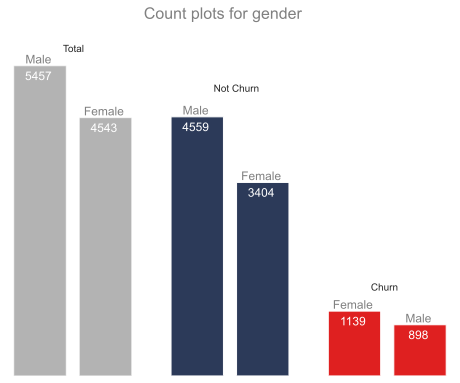

In [243]:
fig, ax = plt.subplots(nrows=1,
                       ncols=3, 
                       sharex=True, 
                       sharey=True, 
                       figsize=(8,6))

ax[0] = sns.countplot('Gender', 
                      data=df,
                      order=df["Gender"].value_counts().index,
                      color='gray',
                      alpha=0.6, 
                      ax=ax[0])

for p, label in zip(ax[0].patches, df["Gender"].value_counts()):
    ax[0].annotate(label, (p.get_x()+0.375, p.get_height()-100),ha='center',
            va='top',
            fontsize=12,
            color='white')
    
for p, label in zip(ax[0].patches, df["Gender"].value_counts().index):
    ax[0].annotate(label, (p.get_x()+0.375, p.get_height()),ha='center',
            va='bottom',
            fontsize=12,
            color='gray')

ax[0].annotate('Total',(0.35,5700))
ax[0].set_ylabel('.', color=(0, 0, 0, 0))

ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].get_yaxis().set_visible(False)
ax[0].get_xaxis().set_visible(False)


ax[1] = sns.countplot('Gender', 
                      data=df.loc[df['Exited'] == 0],
                      order=df.loc[df['Exited'] == 0]["Gender"].value_counts().index,
                      color='#253760', 
                      ax=ax[1])

for p, label in zip(ax[1].patches, df.loc[df['Exited'] == 0]["Gender"].value_counts()):
    ax[1].annotate(label, (p.get_x()+0.375, p.get_height()-100),ha='center',
            va='top',
            fontsize=12,
            color='white')

for p, label in zip(ax[1].patches, df.loc[df['Exited'] == 0]["Gender"].value_counts().index):
    ax[1].annotate(label, (p.get_x()+0.375, p.get_height()),ha='center',
            va='bottom',
            fontsize=12,
            color='gray')    

ax[1].annotate('Not Churn',(0.25,5000))
ax[1].set_ylabel('.', color=(0, 0, 0, 0))

ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].get_xaxis().set_visible(False)

ax[2] = sns.countplot('Gender', 
                      data=df.loc[df['Exited'] == 1], 
                      order=df.loc[df['Exited'] == 1]["Gender"].value_counts().index,
                      color='red',
                      ax=ax[2])

for p, label in zip(ax[2].patches, df.loc[df['Exited'] == 1]["Gender"].value_counts()):
    ax[2].annotate(label, (p.get_x()+0.375, p.get_height()-100),ha='center',
            va='top',
            fontsize=12,
            color='white')

for p, label in zip(ax[2].patches, df.loc[df['Exited'] == 1]["Gender"].value_counts().index):
    ax[2].annotate(label, (p.get_x()+0.375, p.get_height()),ha='center',
            va='bottom',
            fontsize=12,
            color='gray')    

ax[2].annotate('Churn',(0.25,1500))
ax[2].set_ylabel('.', color=(0, 0, 0, 0))

ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
   
ax[2].get_xaxis().set_visible(False)
#plt.tight_layout()
plt.suptitle("Count plots for gender", 
             color='gray',
             fontsize=16)
;

A resposta para esta pergunta pode ser visualizada no gráfico acima. Nele verificamos que, do total dos cliente, a maioria é homem e este comportamento também é observado no conjunto de clientes que não cancelaram seus contratos. Entretanto, quando se verifica o conjunto de cliente que cancelaram seus planos, nota-se que sua maioria é de clientes do gênero femino.

In [14]:
csq=chi2_contingency(pd.crosstab(df['Exited'], df['Gender']))
print("P-value: ",csq[1])

P-value:  2.2482100097131755e-26


Novamente, obtivemos um p-valor inferior a 0.05, indicando que a variável 'Gender' e a 'Exited' não são independentes e, portanto, aquela exerce influência significativa na previsão da variável alvo.

Outro questionamento interessante, que pode ser capaz de influenciar na previsão de o cliente cancelar ou não seu plano, é a respeito da localização geográfica do cliente.

In [146]:
counts_df = df.groupby(["Geography", "Exited"])["Exited"].count().unstack()
percents_df = counts_df.div(counts_df.sum())
percents_df

Exited            0         1
Geography                    
France     0.527942  0.397644
Germany    0.212859  0.399607
Spain      0.259199  0.202749

In [190]:
labels = ['Not Churn', 'Churn']
x = np.arange(len(labels))
width_bar = 0.3
france = list(percents_df.iloc[0,:] * 100)
germany = list(percents_df.iloc[1,:] * 100)
spain = list(percents_df.iloc[2,:] * 100)

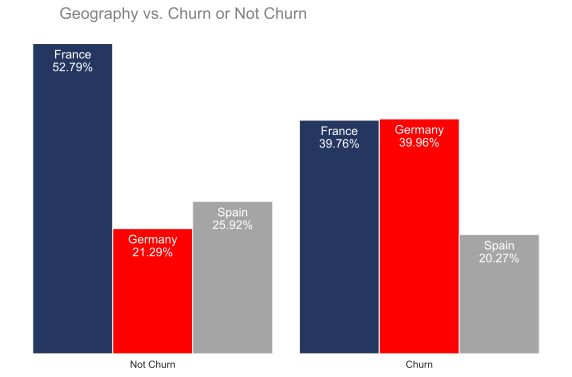

In [244]:
fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - 3*width_bar/3, 
                france, 
                width_bar, 
                label='France',
                color=['#253760'], 
                alpha=1
               )

rects2 = ax.bar(x + 0*width_bar/3, 
                germany, width_bar, 
                label='Germany', 
                color='red', 
                alpha=1
               )

rects3 = ax.bar(x + 3*width_bar/3, 
                spain, width_bar, 
                label='Spain', 
                color='gray', 
                alpha=0.7
               )

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.gca().get_yaxis().set_visible(False)

def autolabel(rects, name):
   
    for rect in rects:
        
        height = round(rect.get_height(),2)
        ax.annotate(
            '{}\n{}%'.format(name,height),
            xy=(rect.get_x() + rect.get_width()/2, height),
            xytext=(0,-30),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=12,
            color='white'
        )
        
        
autolabel(rects1, 'France')
autolabel(rects2, 'Germany')
autolabel(rects3, 'Spain')

plt.text(-0.35, 57, 
         "Geography vs. Churn or Not Churn", 
         fontsize=16, 
         color='gray')

#plt.legend()
#plt.tight_layout()
#plt.savefig('geography.jpg', dpi=400, bbox_inches='tight',format='jpg')
plt.plot();

O gráfico acima mostra que clientes localizados na França tendem a permanecer no banco, enquanto os que estão localizado na Alemanhã tem maior chance de romperem seus contratos.

### 3.2 Análise das variáveis numéricas

Depois da análise das variáveis categóricas, podemos começar a estudar as distribuições das variáveis numéricas para tentar extrair se alguma delas é capaz de ser previsora da variável "Exited", isto é, se há diferença significativa da distribuição das variáveis independentes quando o cliente cancela ou não o contrato.

Para isso, plota-se a curva de distribuição para as variáveis 'Age', 'Credit Score', 'Balance' e 'Estimated Salary'.

''

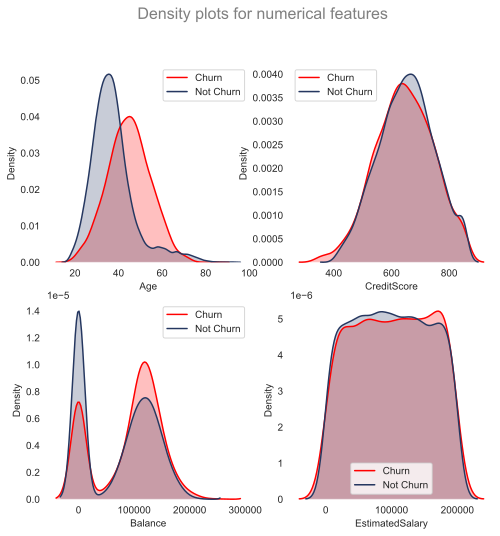

In [245]:
NROWS = 2
NCOLS = 2

fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8,8))

numerical_features = [['Age', 'CreditScore'],
                      ['Balance','EstimatedSalary']]
for i in range(NROWS):
    
    for j in range(NCOLS):
        
        sns.kdeplot(df[df['Exited'] == 1][numerical_features[i][j]],
                    shade=True,
                    color="red",
                    label="Churn",
                    ax=ax[i,j])
        
        sns.kdeplot(df[df['Exited'] == 0][numerical_features[i][j]],
                    shade=True,
                    color="#253760",
                    label="Not Churn",
                    ax=ax[i,j])
        
        ax[i,j].set(xlabel=numerical_features[i][j], ylabel='Density')

        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)

plt.suptitle("Density plots for numerical features", 
             color='gray', 
             fontsize=16)
#plt.savefig('numerical.jpg', dpi=400,bbox_inches='tight',format='jpg')
;
#plt.tight_layout()

Dos gráficos plotados, percebemos de imediato que as variáveis 'Credit Score' e 'Estimated Salary' parece não influenciar no fato de o cliente ter cancelado ou não seu contrato, o que, em certo ponto, é contraintuitivo, uma vez que clientes com maior pontuação de crédito e maiores salários tendem permanecer no banco, enquanto aqueles com salários e pontuação de crédito inferiores tendem a sair.

Além disso, as variáveis 'Age' e 'Balance' possuem distribuições diferentes para clientes que permanecem ou não no banco. Isso pode ser um indicativo de que estas variáveis são boa candidadatas para predizer se um cliente permanecerá ou não no banco.

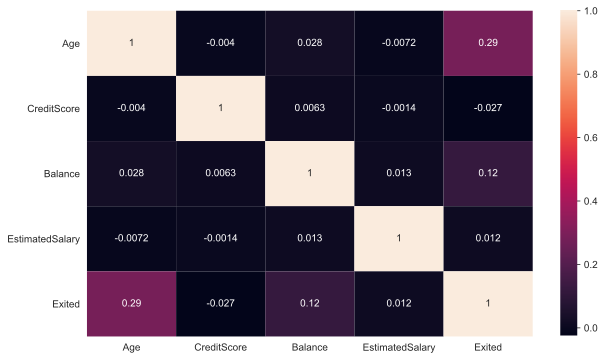

In [246]:
numerical_features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
corrmat = df[numerical_features + ['Exited']].corr().round(4)
plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True)
#plt.tight_layout()
plt.savefig('corr.jpg', dpi=400,bbox_inches='tight',format='jpg');

O mapa de calor com as correlações é uma outra forma de analisar como as variáveis interagem entre si. O mapa acima nos mostra que as variáveis não carregam entre si informações redundantes, isto é, nenhuma delas está formentemente correlacionada. Além disso, como visto nos gráficos de distribuição, os atributos que mais parecem influenciar na variável "Exited" é justamente "Age" e "Balance".

Finalizada a análise exploratória dos dados, podemos proceder à etapa de Engenharia de atributos, na qual iremos manipular os dados a fim de otimizar nosso modelo previsor.

### 3.3 Resumo

Em síntese, as variáveis que mais parecem ser capazes de predizer a fuga de clientes são 'Age', 'IsActiveMember' e 'NumOfProducts', além disso, o gênero e a localização geográfica dos clientes também exercem certa influência na decisão do cliente de cancelar ou não seu contrato.

## 4. Engenharia de atributos

A primeira etapa da engenharia de atributos é verificar se o conjunto de dados apresenta valores faltantes. Caso haja, é necessário proceder à divisão dos dados de treino e teste, de modo a garantir que não haverá vazamento de informações entre os conjuntos de dados e, consequentemente, reduzir a possibilidade de overfitting, para assim realizar a técnica de imputação de dados adequada ao problema.

In [20]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Como o conjunto de dados não apresenta valores faltantes, podemos proceder à análise de Outliers das variáveis numéricas.

### 4.1 Tratamento de Outliers

In [226]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RowNumber','CustomerId','Surname', 'Exited'], axis=1), 
    df['Exited'], 
    test_size=0.15,  
    random_state=0) 

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8500, 10), (1500, 10), (8500,), (1500,))

In [227]:
X_train.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          698   Germany  Female   52       1  107906.75              1   
1          667    France    Male   27       7  156811.74              1   
2          846    France  Female   34      10  142388.61              2   
3          549    France  Female   34       4       0.00              2   
4          510    France  Female   32       1       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               0        168886.39  
1          1               1        149402.59  
2          0               1         68393.64  
3          0               0        139463.57  
4          0               1         28515.17

Após a divisão entre dados de treino e teste, procederemos a um diagnóstico das variáveis numéricas para saber qual será o tratamento adequado dos Outliers. Variáveis cuja distrbuição é a Gaussiana, serão considerados Outliers valores que estejam acima/abaixo da média mais/menos três vezes o desvio padrão. Entretanto, variáveis do mundo real nem sempre possuem uma distribuição perfeitamente Normal e, muitas vezes, apresentam assimetrias. Desse modo, utiliza-se a distância inter-quartílica (DIR) para detecção de Outliers, que é facilmente visualizada pelos Box Plots.  

In [247]:
def diagnostic_plots(df, feature):
    
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    sns.distplot(df[feature], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[feature])
    plt.title('Boxplot')
    
    #plt.tight_layout()
    plt.show();

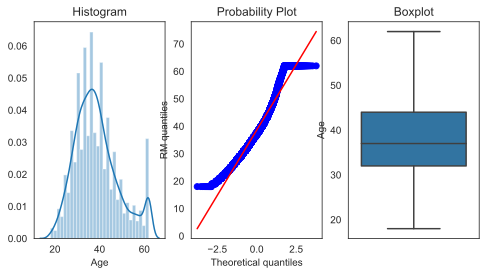

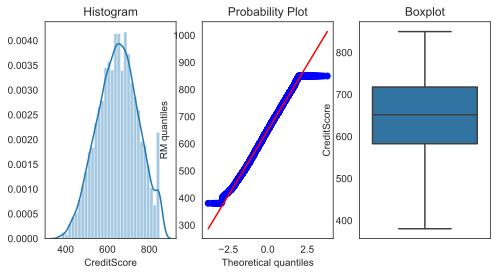

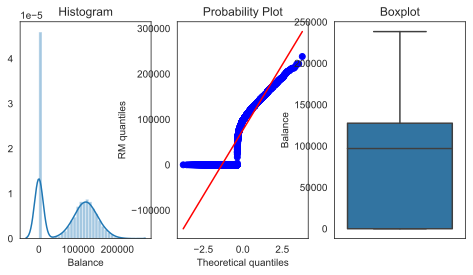

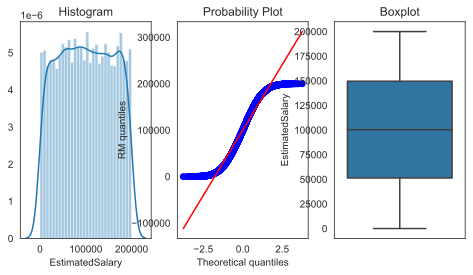

In [248]:
for feature in numerical_features:
    diagnostic_plots(X_train, feature)

O "Probability Plot" do conjunto de gráficos acima mostra a proximidade da distribuição de uma variável, representada pelos pontos azuis, com uma distribuição Normal ideal, mostrada na linha contínua vermelha. A variável 'CreditScore' possui comportamento próximo a um distribuição normal, apresentando Outliers no lado esquerdo da distribuição, de modo que é possível eliminar os Outliers simplesmente imputando a eles valores próximos ao limite inferior da distribuição.

In [230]:
cs_sup_limit = X_train['CreditScore'].mean() + 3 * X_train['CreditScore'].std()
cs_inf_limit = X_train['CreditScore'].mean() - 3 * X_train['CreditScore'].std()

print('Mean + 3 * STD = {}'.format(cs_sup_limit))
print('Mean - 3 * STD = {}'.format(cs_inf_limit))

Mean + 3 * STD = 940.6178195479919
Mean - 3 * STD = 359.822886334361


In [231]:
IQR = X_train['CreditScore'].quantile(0.75) - X_train['CreditScore'].quantile(0.25)

cs_iqr_inf_limit = X_train['CreditScore'].quantile(0.25) - (IQR * 1.5)
cs_iqr_sup_limit = X_train['CreditScore'].quantile(0.75) + (IQR * 1.5)

print('1º Quartile - 1.5 * DIR = {}'.format(cs_iqr_inf_limit))
print('3º Quartile + 1.5 * DIR = {}'.format(cs_iqr_sup_limit))

1º Quartile - 1.5 * DIR = 380.5
3º Quartile + 1.5 * DIR = 920.5


Utilizando a distância inter-quartílica para detecção de Outlier, podemos contabilizar a quantidade de Outliers e para cada exemplo um deles imputar à respectiva variável o valor anteriormente obtido.

In [232]:
print('There are {} clients with more than 920.5 Credit Score'.format(
    len(X_train[X_train['CreditScore'] > cs_iqr_sup_limit])))

print('There are {} clients with less than 380.5 Credit Score'.format(
    len(X_train[X_train['CreditScore'] < cs_iqr_inf_limit])))

There are 0 clients with more than 920.5 Credit Score
There are 13 clients with less than 380.5 Credit Score


In [233]:
X_temp_cs = X_train.copy()

X_train['CreditScore'] = np.where(X_train['CreditScore'] < cs_iqr_inf_limit, 
                                  cs_iqr_inf_limit, X_train['CreditScore'])

print('There are {} clients with less than 380.5 Credit Score'.format(
    len(X_train[X_train['CreditScore'] < cs_inf_limit])))

There are 0 clients with less than 380.5 Credit Score


A imputação anteriormente, apesar de remover o registro do conjunto de dados, altera a distribuição da variável. O plot a seguir mostra o resultado do procedimento.

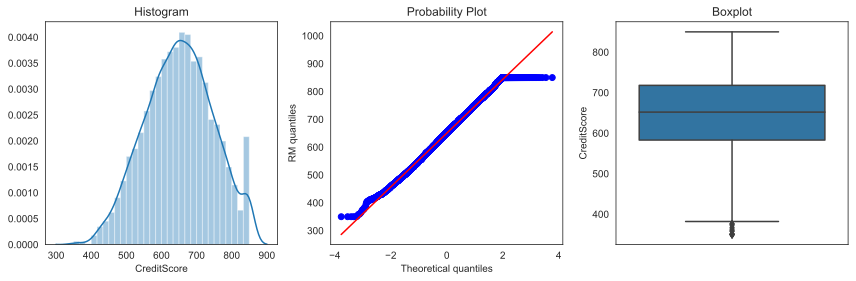

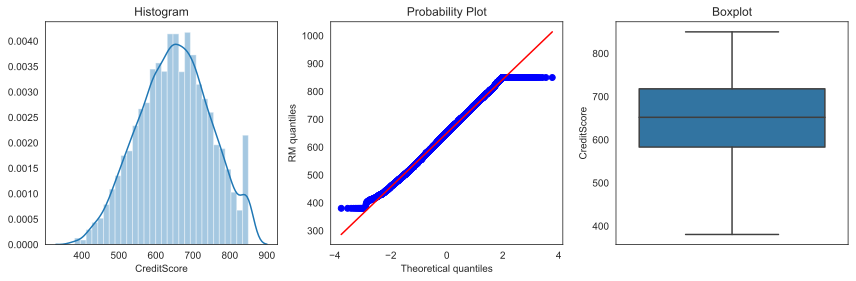

In [239]:
diagnostic_plots(X_temp_cs, 'CreditScore')
diagnostic_plots(X_train, 'CreditScore')

Repetiremos o procedimento anterior para a variável 'Age', que também apresentou Outliers.

In [235]:
IQR = X_train['Age'].quantile(0.75) - X_train['Age'].quantile(0.25)

age_iqr_inf_limit = X_train['Age'].quantile(0.25) - (IQR * 1.5)
age_iqr_sup_limit = X_train['Age'].quantile(0.75) + (IQR * 1.5)

print('1º Quartile - 1.5 * DIR = {}'.format(age_iqr_inf_limit))
print('3º Quartile + 1.5 * DIR = {}'.format(age_iqr_sup_limit))

1º Quartile - 1.5 * DIR = 14.0
3º Quartile + 1.5 * DIR = 62.0


In [236]:
print('There are {} clients with more than 62 years'.format(
    len(X_train[X_train['Age'] > age_iqr_sup_limit])))

print('There are {} clients with less than 14 years'.format(
    len(X_train[X_train['Age'] < age_iqr_inf_limit])))

There are 296 clients with more than 62 years
There are 0 clients with less than 14 years


In [237]:
X_temp_age = X_train.copy()

X_train['Age'] = np.where(X_train['Age'] > age_iqr_sup_limit, 
                                  age_iqr_sup_limit, X_train['Age'])

print('There are {} clients with more than 62 years'.format(
    len(X_train[X_train['Age'] < age_iqr_inf_limit])))

There are 0 clients with more than 62 years


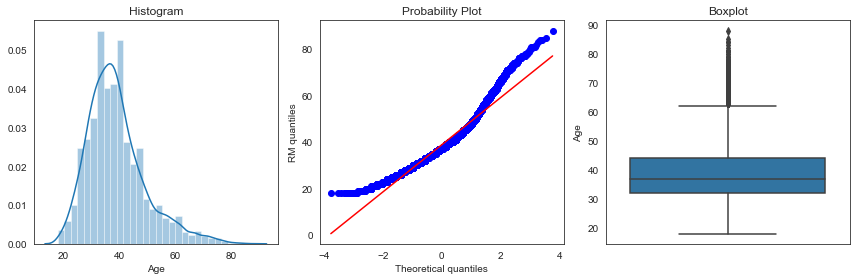

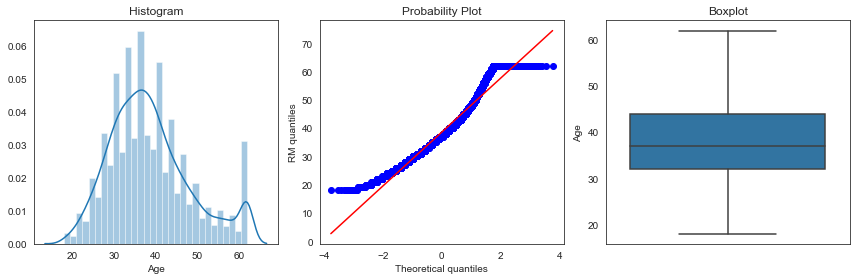

In [33]:
diagnostic_plots(X_temp_age, 'Age')
diagnostic_plots(X_train, 'Age')

In [259]:
#def diagnostic_plots2(df1, df2, feature):
#    
#    fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(8, 4))
#
#    sns.boxplot(y=df1[feature], ax=ax[0])
#    ax[0].set_title('Antes')
#
#    sns.boxplot(y=df2[feature], ax=ax[1])
#    ax[1].set_title('Depois')
#    
#    
#    ax[0].spines['right'].set_visible(False)
#    ax[0].spines['left'].set_visible(False)
#    ax[0].spines['top'].set_visible(False)
#    ax[0].spines['bottom'].set_visible(False)
#
#    #ax[0].get_yaxis().set_visible(False)
#    ax[1].set_ylabel('.', color=(0, 0, 0, 0))
#
#    ax[1].spines['right'].set_visible(False)
#    ax[1].spines['left'].set_visible(False)
#    ax[1].spines['top'].set_visible(False)
#    ax[1].spines['bottom'].set_visible(False)
#
#    ax[1].get_xaxis().set_visible(False)
#
#    plt.savefig(feature+'boxplot.png', dpi=300, format='png')
#    plt.tight_layout()
#    plt.show();

In [261]:
#diagnostic_plots2(X_temp_cs, X_train, 'CreditScore')
#diagnostic_plots2(X_temp_cs, X_train, 'Age')

Finalizado o tratamento dos Outliers, prosseguiremos com o encoding das variáveis categóricas.

### 4.2 Encoding das variáveis categóricas

Para proceder ao encoding das variáveis categóricas, será utilizado o One Hot Encoding para variáveis categóricas não ordinais e Label Encoding para variáveis categóricas binárias. As variáveis 'NumOfProducts', 'HasCrCard' e 'IsActiveMember' já possuem o encoding adequado para o problema e, portanto, devemos proceder ao One Hot Encoding da variável 'Geography' e ao Label Encoding da variável 'Gender'.

In [34]:
X_train.head()

CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0        698.0   Germany  Female  52.0       1  107906.75              1   
1        667.0    France    Male  27.0       7  156811.74              1   
2        846.0    France  Female  34.0      10  142388.61              2   
3        549.0    France  Female  34.0       4       0.00              2   
4        510.0    France  Female  32.0       1       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               0        168886.39  
1          1               1        149402.59  
2          0               1         68393.64  
3          0               0        139463.57  
4          0               1         28515.17

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [36]:
le = LabelEncoder()
le.fit(X_train['Gender'])

LabelEncoder()

In [37]:
le.classes_

array(['Female', 'Male'], dtype=object)

In [38]:
X_train['Gender'] = le.transform(X_train['Gender'])
X_test['Gender'] = le.transform(X_test['Gender'])

X_train.head()

CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0        698.0   Germany       0  52.0       1  107906.75              1   
1        667.0    France       1  27.0       7  156811.74              1   
2        846.0    France       0  34.0      10  142388.61              2   
3        549.0    France       0  34.0       4       0.00              2   
4        510.0    France       0  32.0       1       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               0        168886.39  
1          1               1        149402.59  
2          0               1         68393.64  
3          0               0        139463.57  
4          0               1         28515.17

In [39]:
ohe = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [1])],remainder='passthrough')
tmp = ohe.fit_transform(X_train)

In [40]:
tmp = pd.DataFrame(tmp)

In [41]:
ohe.get_feature_names()

['OneHot__x0_France',
 'OneHot__x0_Germany',
 'OneHot__x0_Spain',
 'CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [42]:
tmp.columns = ohe.get_feature_names()
tmp.head()

OneHot__x0_France  OneHot__x0_Germany  OneHot__x0_Spain  CreditScore  \
0                0.0                 1.0               0.0        698.0   
1                1.0                 0.0               0.0        667.0   
2                1.0                 0.0               0.0        846.0   
3                1.0                 0.0               0.0        549.0   
4                1.0                 0.0               0.0        510.0   

   Gender   Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     0.0  52.0     1.0  107906.75            1.0        1.0             0.0   
1     1.0  27.0     7.0  156811.74            1.0        1.0             1.0   
2     0.0  34.0    10.0  142388.61            2.0        0.0             1.0   
3     0.0  34.0     4.0       0.00            2.0        0.0             0.0   
4     0.0  32.0     1.0       0.00            2.0        0.0             1.0   

   EstimatedSalary  
0        168886.39  
1        149402.59  
2         68393.64  
3        139463.57  
4         28515.17

In [43]:
tmp.shape

(8500, 12)

O mesmo procedimento foi realizado para o conjunto de dados de teste.

In [44]:
X_test.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          597   Germany       0   35       8  131101.04              1   
1          523    France       0   40       2  102967.41              1   
2          706     Spain       0   42       8   95386.82              1   
3          788    France       1   32       4  112079.58              1   
4          706   Germany       1   38       5  163034.82              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        192852.67  
1          1               0        128702.10  
2          1               1         75732.25  
3          0               0         89368.59  
4          1               1        135662.17

In [45]:
tmp_test = ohe.transform(X_test)

tmp_test = pd.DataFrame(tmp_test)
tmp_test.columns = ohe.get_feature_names()

In [46]:
tmp_test.head()

OneHot__x0_France  OneHot__x0_Germany  OneHot__x0_Spain  CreditScore  \
0                0.0                 1.0               0.0        597.0   
1                1.0                 0.0               0.0        523.0   
2                0.0                 0.0               1.0        706.0   
3                1.0                 0.0               0.0        788.0   
4                0.0                 1.0               0.0        706.0   

   Gender   Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     0.0  35.0     8.0  131101.04            1.0        1.0             1.0   
1     0.0  40.0     2.0  102967.41            1.0        1.0             0.0   
2     0.0  42.0     8.0   95386.82            1.0        1.0             1.0   
3     1.0  32.0     4.0  112079.58            1.0        0.0             0.0   
4     1.0  38.0     5.0  163034.82            2.0        1.0             1.0   

   EstimatedSalary  
0        192852.67  
1        128702.10  
2         75732.25  
3         89368.59  
4        135662.17

In [47]:
tmp_test.shape

(1500, 12)

Finalizado o encoding das variáveis categóricas, o passo seguinte será realizar o escalonamento das variáveis numéricas para se obter um melhor desempenho nos modelos preditivos.

### 4.3 Escalonamento das variáveis numéricas

Como os Outliers já foram tratados, o escalonamento das variáveis numéricas consistirá, essencialmente, em realizar uma padronização dos dados, segundo a fórmula: $$x_{new} = \frac{x - \mu}{\sigma},$$ em que $\mu$ é a média e $\sigma$, o desvio padrão.

Este escalonamento será importante para construção de modelos que utilizam cálculo de distância e para acelerar a convergência de modelos que fazem o uso do algorítmo de gradiente descendente. É importante realizar o escalonamento após a divisão de dados entre conjunto de treino e teste, para garantir que não haverá vazamento de informações entre os conjuntos.

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()

In [50]:
X_train_scaled = tmp.copy()
numerical_var = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']

X_train_scaled[numerical_var] = scaler.fit_transform(X_train_scaled[numerical_var])

X_train_scaled.head()

OneHot__x0_France  OneHot__x0_Germany  OneHot__x0_Spain  CreditScore  \
0                0.0                 1.0               0.0     0.493772   
1                1.0                 0.0               0.0     0.173191   
2                1.0                 0.0               0.0     2.024287   
3                1.0                 0.0               0.0    -1.047085   
4                1.0                 0.0               0.0    -1.450396   

   Gender       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0     0.0  1.380075 -1.375734  0.505976            1.0        1.0   
1     1.0 -1.192230  0.697073  1.287699            1.0        1.0   
2     0.0 -0.471985  1.733476  1.057152            2.0        0.0   
3     0.0 -0.471985 -0.339331 -1.218862            2.0        0.0   
4     0.0 -0.677769 -1.375734 -1.218862            2.0        0.0   

   IsActiveMember  EstimatedSalary  
0             0.0         1.193825  
1             1.0         0.854874  
2             1.0        -0.554400  
3             0.0         0.681970  
4             1.0        -1.248147

In [51]:
X_test_scaled = tmp_test.copy()

X_test_scaled[numerical_var] = scaler.fit_transform(X_test_scaled[numerical_var])

X_test_scaled.head()

OneHot__x0_France  OneHot__x0_Germany  OneHot__x0_Spain  CreditScore  \
0                0.0                 1.0               0.0    -0.576977   
1                1.0                 0.0               0.0    -1.349388   
2                0.0                 0.0               1.0     0.560763   
3                1.0                 0.0               0.0     1.416678   
4                0.0                 1.0               0.0     0.560763   

   Gender       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0     0.0 -0.407935  0.980101  0.867586            1.0        1.0   
1     0.0  0.057673 -1.109667  0.409586            1.0        1.0   
2     0.0  0.243917  0.980101  0.286179            1.0        1.0   
3     1.0 -0.687300 -0.413077  0.557927            1.0        0.0   
4     1.0 -0.128570 -0.064783  1.387450            2.0        1.0   

   IsActiveMember  EstimatedSalary  
0             1.0         1.626269  
1             0.0         0.513293  
2             1.0        -0.405704  
3             0.0        -0.169121  
4             1.0         0.634046

Com os dados devidamente tratados, podemos seguir para a construção do modelo preditivo.

## 5. Construção e avaliação do modelo

A primeira parte da construção do modelo será uma checagem básica do desempenho dos seguintes classificadores:
* Random Forest
* Regressor Logístico
* Gradient Boost Classifier
* K-Nearest Neighbours
* Máquinas de Vetores Suporte

Para a avaliação desses algoritmos utilizaremos as métricas: Recall, ROC-AUC e F1-Score. O recall de um modelo nos diz a taxa de acerto das classificações positivas, isto é, dos exemplos que são positivos, quantos foram classificados corretamente; desse modo, o recall é bastante útil na avaliação do desempenho de modelos em conjuntos de dados desbalanceados e, por esse motivo, será o principal fator de avaliação de um algoritmo.

In [52]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_curve, precision_score, recall_score

In [53]:
def makePredictions(model, X_test, y_test):
    
    result = model.predict(X_test)
    
    score = f1_score(y_test, result)
    conf_matrix = confusion_matrix(y_test, result)
    roc_auc = roc_auc_score(y_test, result)
    recall = recall_score(y_test, result)
    accu = accuracy_score(y_test, result)
    
    print('Model F1-Score: {}\n'.format(score))
    print('Model Accuracy: {}\n'.format(accu))
    print('Model Recall: {}\n'.format(recall))
    print('ROC-AUC: {}\n'.format(roc_auc))
    print('Confusion Matrix:\n {}\n'.format(conf_matrix))

In [54]:
def trainModels(models, X_train, y_train, X_test, y_test):
    
    for model in models:

        print('-' * 30)
        print('Training model: {}'.format(model[0]))

        model[1].fit(X_train, y_train)

        print('Model Results:\n')

        makePredictions(model[1], X_test, y_test)

In [55]:
clf_rf = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state=0)
clf_lr = LogisticRegression(random_state=1, class_weight='balanced')
clf_xgb = XGBClassifier(learning_rate=0.02,n_estimators=600,objective='binary:logistic',random_state=1)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_svm = SVC()

models = [
    ('Random Forest', clf_rf),
    ('Logistic Regressor', clf_lr),
    ('XGB Classifier', clf_xgb),
    ('K-Nearest Neighbours', clf_knn),
    ('Support Vector Classifier', clf_svm)
]

In [56]:
trainModels(models, X_train_scaled, y_train, X_test_scaled, y_test)

------------------------------
Training model: Random Forest
Model Results:

Model F1-Score: 0.5976095617529881

Model Accuracy: 0.8653333333333333

Model Recall: 0.49019607843137253

ROC-AUC: 0.7258350576411469

Confusion Matrix:
 [[1148   46]
 [ 156  150]]

------------------------------
Training model: Logistic Regressor
Model Results:

Model F1-Score: 0.5115740740740742

Model Accuracy: 0.7186666666666667

Model Recall: 0.7222222222222222

ROC-AUC: 0.7199888330541597

Confusion Matrix:
 [[857 337]
 [ 85 221]]

------------------------------
Training model: XGB Classifier
Model Results:

Model F1-Score: 0.5941747572815534

Model Accuracy: 0.8606666666666667

Model Recall: 0.5

ROC-AUC: 0.7265494137353433

Confusion Matrix:
 [[1138   56]
 [ 153  153]]

------------------------------
Training model: K-Nearest Neighbours
Model Results:

Model F1-Score: 0.46153846153846156

Model Accuracy: 0.8226666666666667

Model Recall: 0.37254901960784315

ROC-AUC: 0.6552862350970539

Confusion Matr

Dos resultados acima, observamos que, apesar da acurácia estar alta, os modelos propostos não apresentaram bom desempenho, uma vez que estes resultados são consequências do desbalanceamento das classes. Além disso, nenhum modelo conseguiu entregar uma boa performance na classificação de clientes que cancelaram seus contratos (baixo recall) e, por isso, passaremos ao tratamento dos dados desbalanceados.

### 5.1 Tratamento de dados desbalanceados

Como visto, as classes do conjunto de dados encontram-se desbalanceadas, isto é, a quantidade de clientes que mantém seu contrato ativo é significativamente maior que a quantidade de clientes que cancelam seus contratos.

In [57]:
print(round(y_train.value_counts()/len(y_train)*100, 2))

0    79.64
1    20.36
Name: Exited, dtype: float64


Para corrigir o desbalanceamento existem diversas técnicas, como a introdução de pesos para cada classe, a subamostragem, sobreamostragem, entre outros. A técnica escolhida aqui será a de sobreamostragem, ou seja, aumentaremos a quantidade de exemplos da classe minoritária, através do algoritmo SMOTE. Este algoritmo sintetiza novos exemplos da classe minoritária a partir de um agrupamento de exemplos existentes da classe minoritária e, desse agrupamento, gera um novo exemplo com características semelhantes.

In [94]:
from imblearn.over_sampling import SMOTE, ADASYN
smk = SMOTE()
adasyn = ADASYN()

X_train_over, y_train_over = smk.fit_sample(tmp, y_train)
#X_train_over, y_train_over = adasyn.fit_sample(tmp, y_train)

X_train_over.shape, y_train_over.shape

((13639, 12), (13639,))

In [95]:
y_train_over.value_counts()

1    6870
0    6769
Name: Exited, dtype: int64

Após corrigido o desbalanceamento, devemos realizar novamente o escalonamento das variáveis numéricas para seguir com o treinamento.

In [96]:
X_train_over_scaled = X_train_over.copy()

X_train_over_scaled[numerical_var] = scaler.fit_transform(X_train_over_scaled[numerical_var])

In [97]:
trainModels(models,
            X_train_over_scaled, 
            y_train_over, 
            X_test_scaled, 
            y_test)

------------------------------
Training model: Random Forest
Model Results:

Model F1-Score: 0.6030664395229983

Model Accuracy: 0.8446666666666667

Model Recall: 0.5784313725490197

ROC-AUC: 0.7456645974972904

Confusion Matrix:
 [[1090  104]
 [ 129  177]]

------------------------------
Training model: Logistic Regressor
Model Results:

Model F1-Score: 0.49895178197065

Model Accuracy: 0.6813333333333333

Model Recall: 0.7777777777777778

ROC-AUC: 0.7171970965940815

Confusion Matrix:
 [[784 410]
 [ 68 238]]

------------------------------
Training model: XGB Classifier
Model Results:

Model F1-Score: 0.63125

Model Accuracy: 0.8426666666666667

Model Recall: 0.6601307189542484

ROC-AUC: 0.7747889775675764

Confusion Matrix:
 [[1062  132]
 [ 104  202]]

------------------------------
Training model: K-Nearest Neighbours
Model Results:

Model F1-Score: 0.5089686098654709

Model Accuracy: 0.708

Model Recall: 0.7418300653594772

ROC-AUC: 0.720580024304529

Confusion Matrix:
 [[835 359]

Os novos resultados mostram um aumento significativo no desempenho dos algoritmos. Os modelos que mais se destacaram foram o Random Forest e o XGBoost Classifier, que consiguiram classificar com bom desempenho ambas as classes. Estes modelos terão seus hiperparâmetros otimizados a fim de se obter o melhor desempenho possível, com vistas a maximar a margem de acertos do modelo para reduzir a fuga de clientes.

### 5.2 Otimização dos Hiperparâmetros

A etapa de otimização dos hiperparâmetros é muito importante, uma vez que é nela que conseguimos tirar o máximo do nosso modelo. O método de otimização escolhido aqui foi o Randomized Search, que consiste em definir um conjunto de parâmetros de configuração e, a partir desse conjunto, o modelo escolhe aleatoriamente parâmetros e calcula sua pontuação. O método foi aplicado tanto para o XGBoost Classifier quanto para o Random Forest, modelos que apresentaram melhor desempenho na etapa anterior.

Iniciaremos com a otimização do XGBoost.

In [65]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [99]:
random_search = RandomizedSearchCV(clf_xgb, 
                                   param_distributions=params_xgb, 
                                   n_iter=10, 
                                   scoring='recall', 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=1001 )

In [100]:
random_search.fit(X_train_over_scaled, y_train_over)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.350, total=   3.7s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.858, total=   3.4s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.987, total=   3.6s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.987, total=   3.6s
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.987, total=   4.2s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.336, total=   5.5s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8, score=0.870, total=   5.1s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subs

[CV]  subsample=0.8, min_child_weight=1, max_depth=5, gamma=0.5, colsample_bytree=0.6, score=0.991, total=   4.6s
[CV] subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6, score=0.334, total=   4.2s
[CV] subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6, score=0.866, total=   4.0s
[CV] subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6, score=0.992, total=   4.1s
[CV] subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV]  subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6, score=0.993, total=   3.8s
[CV] subsample=0.8, min_child_weight=1, max_depth=4, gamma=1.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.6min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=6, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=600, n_jobs=0,
                                           num_parallel_tree=1, random_state=1,
                                           reg_alpha=0, reg_lambda=1,
                                           sca

In [101]:
print('\n Estimator: {}'.format(random_search.best_estimator_))
print('\n Hyperparameters: {}'.format(random_search.best_params_))


 Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Hyperparameters: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 1.0}


In [102]:
makePredictions(random_search.best_estimator_, 
                X_test_scaled, y_test)

Model F1-Score: 0.6257668711656442

Model Accuracy: 0.8373333333333334

Model Recall: 0.6666666666666666

ROC-AUC: 0.7738693467336683

Confusion Matrix:
 [[1052  142]
 [ 102  204]]



O modelo XGBoost não apresentou melhora significativa após a otimização dos hiperparâmetros e, daí, seguiremos com a otimização do Random Forest.

In [103]:
params_rf = { 
    'n_estimators': [25, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [104]:
random_search_rf = RandomizedSearchCV(clf_rf, 
                                   param_distributions=params_rf, 
                                   n_iter=10, 
                                   scoring='recall', 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=1001 )

In [105]:
random_search_rf.fit(X_train_over_scaled, y_train_over)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, max_features=auto, max_depth=7, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, max_features=auto, max_depth=7, criterion=entropy, score=0.410, total=   3.0s
[CV] n_estimators=200, max_features=auto, max_depth=7, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  n_estimators=200, max_features=auto, max_depth=7, criterion=entropy, score=0.855, total=   3.1s
[CV] n_estimators=200, max_features=auto, max_depth=7, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV]  n_estimators=200, max_features=auto, max_depth=7, criterion=entropy, score=0.976, total=   3.0s
[CV] n_estimators=200, max_features=auto, max_depth=7, criterion=entropy 
[CV]  n_estimators=200, max_features=auto, max_depth=7, criterion=entropy, score=0.980, total=   3.4s
[CV] n_estimators=200, max_features=auto, max_depth=7, criterion=entropy 
[CV]  n_estimators=200, max_features=auto, max_depth=7, criterion=entropy, score=0.977, total=   2.8s
[CV] n_estimators=200, max_features=auto, max_depth=8, criterion=entropy 
[CV]  n_estimators=200, max_features=auto, max_depth=8, criterion=entropy, score=0.404, total=   3.1s
[CV] n_estimators=200, max_features=auto, max_depth=8, criterion=entropy 
[CV]  n_estimators=200, max_features=auto, max_depth=8, criterion=entropy, score=0.855, total=   3.1s
[CV] n_estimators=200, max_features=auto, max_depth=8, criterion=entropy 
[CV]  n_estimators=200, max_features=auto, max_depth=8, criterion=entropy, score=0.984, total=   3.1s
[CV] n_estimators=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=40,
                                                    random_state=0),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [25, 50, 100, 200,
                                                         500]},
                   random_state=1001, scoring='recall', verbose=3)

In [106]:
print('\n Estimator: {}'.format(random_search_rf.best_estimator_))
print('\n Hyperparameters: {}'.format(random_search_rf.best_params_))


 Estimator: RandomForestClassifier(max_depth=7, max_features='log2', random_state=0)

 Hyperparameters: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini'}


In [107]:
makePredictions(random_search_rf.best_estimator_, 
                X_test_scaled, y_test)

Model F1-Score: 0.6185243328100472

Model Accuracy: 0.838

Model Recall: 0.6437908496732027

ROC-AUC: 0.7657815219890302

Confusion Matrix:
 [[1060  134]
 [ 109  197]]



Diferentemente do XGBoost, o Random Forest apresentou uma boa melhora de desempenho, principalmente no que diz respeito ao Recall e à pontuação ROC-AUC. Com os hiperparâmetros otimizados, combinaremos os classificadores para extrairmos o melhor preditor.

### 5.3 Combinação de Modelos

Com os hiperparâmetros dos modelos unitários otimizados, realizaremos a combinação dos melhores modelos obtidos: Random Forest, XGBoost Classifier e o Regressor Logístico. Os métodos escolhidos para combinação de modelos foi o que implementa o voto de maioria (Majority Voter), que seleciona a classe a partir da soma das predições de cada modelos unitário penderado por pesos predeterminados; e o empilhamento de modelos (Stacking Classifier), que consiste e utilizar a saída de um estimador para calcular a predição da classe.

In [108]:
chosen_models = [
    ('Random Forest', random_search_rf.best_estimator_),
    ('Logistic Regressor', clf_lr),
    ('XGB Classifier', random_search.best_estimator_),
    #('K-Nearest Neighbours', clf_knn),
    #('Support Vector Classifier', clf_svm)
]

In [109]:
vclf = VotingClassifier(estimators=chosen_models, voting='soft', weights=[3,4,5])
vclf = vclf.fit(X_train_over_scaled, y_train_over)

In [110]:
makePredictions(vclf, X_test_scaled, y_test)

Model F1-Score: 0.6346967559943584

Model Accuracy: 0.8273333333333334

Model Recall: 0.7352941176470589

ROC-AUC: 0.7931076953394424

Confusion Matrix:
 [[1016  178]
 [  81  225]]



O Majority Voter apresentou um excelente desempenho para a tarefa proposta, uma vez que conseguiu acurácia acima da proporção de classes e, principalmente, pelo fato de ter apresentado recall > 73%, isto é, o modelo obtido consegue com sucesso prever a classe minoritária em um conjunto de dados desbalanceado. Este modelo tem grande potencial para ser colocado em produção.

In [111]:
stack_clf = StackingClassifier(chosen_models,
                               final_estimator=random_search_rf.best_estimator_,
                               cv=2) 

In [112]:
stack_clf.fit(X_train_over_scaled, y_train_over)

StackingClassifier(cv=2,
                   estimators=[('Random Forest',
                                RandomForestClassifier(max_depth=7,
                                                       max_features='log2',
                                                       random_state=0)),
                               ('Logistic Regressor',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=1)),
                               ('XGB Classifier',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1.0, gamma=1,
                                              gpu_id=-1, impo...
                                              max_delta_step=0, max_depth=4,
                            

In [113]:
makePredictions(stack_clf, X_test_scaled, y_test)

Model F1-Score: 0.6137931034482758

Model Accuracy: 0.8506666666666667

Model Recall: 0.5816993464052288

ROC-AUC: 0.7506486681774888

Confusion Matrix:
 [[1098   96]
 [ 128  178]]



O Stacking Classifier, por sua vez, não apresentou bom desempenho, apesar da elevada acurácia. Por este motivo, seguiremos adiante com o Voting Classifier.

## 6. Seleção de atributos

A etapa de seleção de atributos ocorre, geralmente, após a de Engenharia de Atributos e antes da construção do Modelo, entretanto, como o conjunto de dados não possuia quantidade significativa de atributos e, por isso, consistiu, essencialmente, na remoção das colunas 'RowNumber', 'CustomerId' e 'Surname', as quais não possuiam capacidade preditiva.

Agora, para a praticidade de uso do usuário final, a quantidade de atributos do modelo original não se mostrava interessente e, por este motivo, reduziremos o número de características para 5. Utilizaremos o Random Forest anteriormente treinado para obtermos os atributos que mais influenciam na classificação dos exemplos. 

In [82]:
random_search_rf.best_estimator_.fit(X_train_over_scaled, y_train_over)

importance = pd.concat(
    [pd.Series(X_train_over_scaled.columns),
     pd.Series(random_search_rf.best_estimator_.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

feature  importance
5                  Age    0.225344
8        NumOfProducts    0.191784
10      IsActiveMember    0.186443
4               Gender    0.111735
0    OneHot__x0_France    0.088020
1   OneHot__x0_Germany    0.086478
2     OneHot__x0_Spain    0.034390
9            HasCrCard    0.033715
7              Balance    0.024883
6               Tenure    0.006473
11     EstimatedSalary    0.005421
3          CreditScore    0.005314

O resultado desse procedimento apenas nos confirma o que a Análise Exploratória de Dados nos mostrou. As variáveis 'Age', 'NumOfProducts', 'IsActiveMember', 'Gender' e a localização geográfica dos clientes são as mais importantes quando se deseja prever a probabilidade do cliente entrar em "Churn".

In [83]:
vclf.fit(X_train_over_scaled[['Age',
                              'NumOfProducts',
                              'IsActiveMember',
                              'Gender',
                              'OneHot__x0_France',
                              'OneHot__x0_Germany',
                              'OneHot__x0_Spain']], y_train_over)

#clf.fit(X_train_over_scaled, y_train_over)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_depth=7,
                                                     max_features='log2',
                                                     random_state=0)),
                             ('Logistic Regressor',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=1)),
                             ('XGB Classifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.8, gamma=1.5,
                                            gpu_id=-1, importanc...e='gain',
                                            interaction_constraints='',
                                            learning_rate=0.02,
    

In [84]:
makePredictions(vclf, X_test_scaled[['Age',
                              'NumOfProducts',
                              'IsActiveMember',
                              'Gender',
                              'OneHot__x0_France',
                              'OneHot__x0_Germany',
                              'OneHot__x0_Spain']], y_test)

Model F1-Score: 0.6241519674355496

Model Accuracy: 0.8153333333333334

Model Recall: 0.7516339869281046

ROC-AUC: 0.7916461391926954

Confusion Matrix:
 [[993 201]
 [ 76 230]]



Como esperado, o modelo treinado apenas com os atributos de maior importância apresenta um ótimo desempenho, já que possui acurácia acima da proporção das classes e entregou um recall acima de 70%, indicando que consegue prever com êxito a classe minoritária.

### 7. Pipeline para Engenharia de Atributos

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RowNumber','CustomerId','Surname', 'Exited'], axis=1), 
    df['Exited'], 
    test_size=0.15,  
    random_state=0) 

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8500, 10), (1500, 10), (8500,), (1500,))

In [86]:
X_train.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          698   Germany  Female   52       1  107906.75              1   
1          667    France    Male   27       7  156811.74              1   
2          846    France  Female   34      10  142388.61              2   
3          549    France  Female   34       4       0.00              2   
4          510    France  Female   32       1       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               0        168886.39  
1          1               1        149402.59  
2          0               1         68393.64  
3          0               0        139463.57  
4          0               1         28515.17

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [88]:
scaler = StandardScaler()
ohe    = OneHotEncoder()
oe = OrdinalEncoder()

features = X_test.columns

numeric_features = ['Age', 'CreditScore','Tenure','Balance', 'EstimatedSalary']
categorical_features = ['Gender']
ohe_features = ['Geography']


numeric_transformer = Pipeline(steps=[
    ('scaler', scaler)
])

categorical_transformer = Pipeline(steps=[
    ('encoder', oe)
])

ohe_transformer = Pipeline(steps=[
    ('onehot', ohe)
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, features[[3, 0, 4, 5, 9]]),
    ('cat', categorical_transformer, features[[2]]),
    ('ohe', categorical_transformer, features[[1]])
])

In [89]:
#features = X_test.columns
#features[[1]]

In [90]:
#abc = preprocessor.fit_transform(X_test)

In [91]:
#abc = pd.DataFrame(abc, columns = features[[3, 0, 4, 5, 9, 2, 1]])

In [92]:
#abc

In [93]:
#X_test_scaled